# Description:
In this notebook we experiment with the log-loss function. We compare different methods to convert the cosine similarities to probabilities.

# TODO:

In [1]:
import os
import re
from collections import defaultdict, namedtuple
from itertools import product
from pathlib import Path
from random import choice, sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim import models
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Finding project_dir
project_dir = Path().resolve().parents[0]
data_file = os.path.join(
    project_dir, "data", "processed", "newsapi_docs.csv")
model_dir = os.path.join(project_dir, "models", "saved_models")
model_files = [os.path.join(model_dir, f) for f in os.listdir(
    model_dir) if re.search("^doc2vec.*\.model$", f)]

# Data structure for holding data for each document
NewsDocument = namedtuple(
    'NewsDocument', ['tags', 'id', 'col', 'category', 'words', 'split', 'original'])


In [3]:
# Reading data into memory
df = pd.read_csv(data_file, names=[
                 'id', 'col', 'category', 'text', 'split', 'prep_text'])

# Formatting data from DataFrame to Named Tuple for doc2vec training
all_docs = [
    NewsDocument([tag], row['id'], row['col'], row['category'], row['prep_text'].split(),
                 row['split'], row['text']) for tag, (_, row) in enumerate(df.iterrows())
    if row['prep_text'] is not None
]
train_docs = [doc for doc in all_docs if doc.split == 'train']
test_docs = [doc for doc in all_docs if doc.split == 'test']
del df

In [4]:
# Loading fitted models
model_instance = models.doc2vec.Doc2Vec.load(model_files[0])

# Creating objects to store data inside loop
model_out = defaultdict(lambda: [])

In [5]:
# Creating constants (invariable across loop iterations)
# sample train docs to evaluate inferred vs learned vectors
train_samples = sample(train_docs, k=1000)
test_doc_eval = choice(test_docs)  # random test doc to evaluate distances
train_targets = [doc.category for doc in train_docs]
test_targets = [doc.category for doc in test_docs]

# Evaluating fitted model
modelname = str(model_instance)

# Get document vectors and targets
train_vecs = [model_instance.docvecs[doc.tags[0]] for doc in train_docs]
test_vecs = [model_instance.infer_vector(doc.words) for doc in test_docs]

# Cosine similarity of test set instances
sim_matrix = cosine_similarity(test_vecs)

# Returns tuple with two arrays, each with the indices along one dimension
tri_idx = np.triu_indices(len(test_targets), 1)

# Pairs row and col indices and checks if corresponding observations have the same label
y_labels = np.array([1 if test_targets[i] == test_targets[j] else 0 for i, j in zip(*tri_idx)])

In [6]:
# Log-loss of predicting whether pairs of observations belong to the same category
k = 4
# Convert cosine similarities to probability matrix using sigmoid function
prob_matrix_sigmoid = 1/(1 + np.exp(-k*sim_matrix))
# Get upper triangle of probability matrix to array
y_pred_sigmoid = prob_matrix_sigmoid[tri_idx]  # the N(N−1)/2 independent predictions
# Binary cross-entropy
log_loss_sigmoid = y_labels * np.log(y_pred_sigmoid) + (1 - y_labels) * np.log(1 - y_pred_sigmoid)
cost_sigmoid = -1 * np.mean(log_loss_sigmoid)

print("Model %s log-loss: %f\n" % (modelname, cost_sigmoid ))

Model Doc2Vec(dm/c,d100,n5,w5,mc2,t4) log-loss: 0.782707



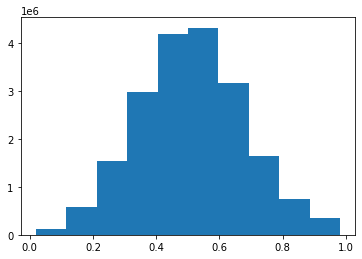

In [7]:
plt.hist(y_pred_sigmoid)
plt.show()

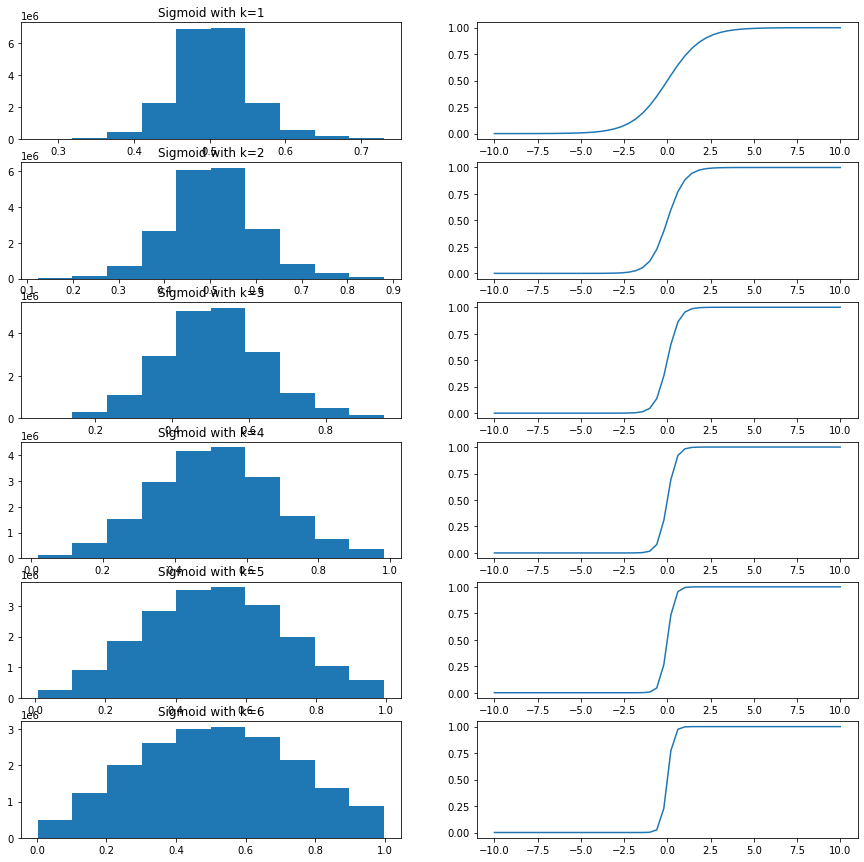

In [8]:
fig, axes = plt.subplots(6, 2, figsize=(15,15))
x = np.linspace(-10, 10, 50)
for k, ax in enumerate(axes, start=1):
    ax1, ax2 = ax
    y = 1/(1 + np.exp(-k*x))
    # Convert cosine similarities to probability matrix using sigmoid function
    prob_matrix_sigmoid = 1/(1 + np.exp(-k*sim_matrix))
    # Get upper triangle of probability matrix to array
    y_pred_sigmoid = prob_matrix_sigmoid[tri_idx]  # the N(N−1)/2 independent predictions
    ax1.hist(y_pred_sigmoid)
    ax2.plot(x, y)
    ax1.set_title(f"Sigmoid with k={k}")

plt.show()

We can see above how the output probabilities varies according to k. Also how the sigmoid function looks for different k. One thing to notice is that for low values of k, our probabilities won't vary between 0 and 1 but on a smaller range because the sigmoid isn't steep enough.

In [9]:
# Get unique similarities (upper triangle) 
sim_unique = np.expand_dims(sim_matrix[tri_idx], axis=1)
# Get probability array of unique upper triangle using MinMaxScaler [0.001, 0.999] to avoid 0 value 
y_pred_minmax = MinMaxScaler((0.001, 0.999)).fit_transform(sim_unique)[:, 0]
# Binary cross-entropy
log_loss_minmax = y_labels * np.log(y_pred_minmax) + (1 - y_labels) * np.log(1 - y_pred_minmax)
cost_minmax = -1 * np.mean(log_loss_minmax)

print("Model %s log-loss: %f\n" % (modelname, cost_minmax))

Model Doc2Vec(dm/c,d100,n5,w5,mc2,t4) log-loss: 0.721333



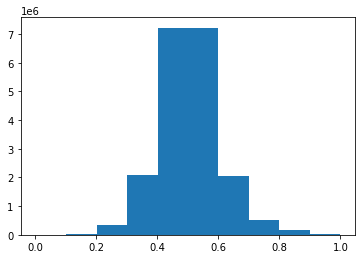

In [10]:
plt.hist(y_pred_minmax)
plt.show()

For the minmax scaling it seems that the probabilites are mainly concentrated on 0.5 which isn't something we are looking for.